In [5]:
## Inverse Jaccard and Cosine similarity of trace documents 
## Minimum Spanning Tree of Cosine and Jaccard similarity matrices 
## Louvain and Girvan Newman Community Detection on MSTs
## Classification of communities: Naive Bayes, Decision Trees, Random Forest 

In [6]:
### SIMILARITY MATRIX AND NETWORKX GRAPH 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import VarianceThreshold 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn import metrics
import community as community_louvain

from itertools import chain, combinations, cycle
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.cluster.hierarchy import dendrogram
from scipy.sparse import csr_matrix
from scipy import interp

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# Calculate similarity between documents with Cosine
# documents - array of all untokenized trace documents 
# Returns cosine simlarity matrix of size #documents x #documents 
# similarityMatrix[1][2] = cosine simlarity between document1 and document2
def SM_cosine(documents):
    vectorizer = TfidfVectorizer()
    
    # tokenize and build vocabulary of all documents
    # vectors created for each document 
    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    # cosine simlarity between all document vectors 
    cosine_matrix = cosine_similarity(feature_matrix) 

    return cosine_matrix;

# Invert similarity matrix values for Cosine MST
# similarity matrix array 
# Returns similarity matrix with inverted values 
def inverted_matrix(similarity_matrix): 
    inv_sm = []
    for x in similarity_matrix:
        temp = []
        for y in x: # for every value in similarity_matrix
            if y == 0:
                temp.append(9999)
            else:
                temp.append(1/y)
    
        inv_sm.append(temp)
        
    return inv_sm

# Calculate inverted similarity between documents with Jaccard
# documents - array of all untokenized trace documents 
# Returns inverted jaccard simlarity matrix of size #documents x #documents 
# similarityMatrix[1][2] = jaccard simlarity between document1 and document2
def SM_invjaccard(documents):
    matrix = []
    for x in documents:
        temp = []
        for y in documents:
            a = set(x.split(' ')) # tokenize document x
            b = set(y.split(' ')) # tokenize document y
            c = a.intersection(b) # find intersection between two trace docuemnts: x, y 
            j = float(len(c)) / (len(a) + len(b) - len(c)) # jaccard calculation
            
            inv = 0 # inverse jaccard values
            if j == 0:
                inv = 9999
            else:
                inv = float(1/j) 
            
            temp.append(inv)
        matrix.append(temp)

    return matrix;
     
# Graph similarity between trace documents and find MST    
# matrix - Inverted cosine or jaccard similarity matrix
# labels - dict of document names 
# RETURNS MST GRAPH
def networkX_graph(matrix, labels):
    
    G = nx.from_numpy_matrix(np.array(matrix)) # plot similarity matrix 
    H = nx.relabel_nodes(G, labels) # label nodes with names of each trace
    
    mst = nx.algorithms.tree.mst.minimum_spanning_tree(H) #MST of similarity matrix
    #draw graph 
    #nx.draw(H, layout, with_labels=True)
    return mst

In [3]:
### COMMUNITY DETECTION
# Families created from MST and Girvan Newman 
# G - NX MST graph of cosine or jaccard
# name_trace_dict[trace_name] = trace_document  
# maxgroups - number of groups desired
# Returns all_traces_list - [list of all tracedoc, list of labelled families, list of tracedoc names]
def all_traces_clusters_girvan_newman(G, name_trace_dict, maxgroups):   
        gn = nx.algorithms.community.centrality.girvan_newman(G) # girvan newman community detection on MST 
        
        sets_of_cluster = [] # find all iterations with desired number of groups
        for x in gn:
            if len(x) == maxgroups:
                sets_of_cluster.append(x)
        
        sets_of_cluster = sets_of_cluster[0] # take first iteration with desired number of groups
        #print("\n\n\n", sets_of_cluster)

        list_of_cluster = [] # list of communities and tracedocs within them
        target_labels = [] #list of distinct communities detected
        for x in range(len(sets_of_cluster)): 
            list_of_cluster.append(list(sets_of_cluster[x]))
            target_labels.append(x)
    
        #print("\n\n\n", list_of_cluster)  

        all_traces_list = []
        all_traces = [] # list of all trace documents
        all_traces_names = [] # list of names of trace documents
        all_labels = [] # list of labelled families of trace documents
        for x in range(len(list_of_cluster)):
            for y in list_of_cluster[x]:
                y = int(y)
                all_traces_names.append(y)
                all_traces.append(name_trace_dict[y])
                all_labels.append(x)
        
        # List of trace documents, List of detected family label, List of tracedoc names
        all_traces_list = [all_traces, all_labels, all_traces_names]
        
        # print family/cluster/group number and the trace document names in each
        print("\nGIRVAN NEWMAN COMMUNITY DETECTION FAMILIES: \n")
        for y in target_labels:
            print("\n\nGroup ", y, ":  ", end =" ")
            for x in range(len(all_traces)):
                if all_labels[x] == y:
                    print(all_traces_names[x], end =", ")
        
        return all_traces_list;


# Families created from MST and Louvain 
# G - NX MST graph of cosine or jaccard
# name_trace_dict[trace_name] = trace_document  
# Returns all_traces_list - [list of all tracedoc, list of labelled families, list of tracedoc names]
def all_traces_clusters_louvain(G, name_trace_dict):
    lv = community_louvain.best_partition(G) # louvain community detection on MST 

    lv_traces = list(lv.keys())
    lv_groups = list(lv.values())
    lv_distinct_groups = sorted(list(set(lv_groups)))

    lv_families  = []
    for x in lv_distinct_groups:
        temp = []
        for y in range(len(lv_groups)):
            if x == lv_groups[y]:
                temp.append(lv_traces[y])
        
    
        lv_families.append(temp)
    
    print("\n\nLOUVAIN COMMUNITY DETECTION FAMILIES: \n")
    i=0
    all_traces = []
    all_labels = []
    all_traces_names = []
    for x in lv_families:
        print("\nGroup ", i, ": ", x)
        
        for y in x:
            y = int(y)
            all_traces.append(name_trace_dict[y])
            all_traces_names.append(y)
            all_labels.append(i)
            
        i+=1
    
    all_traces_list = [all_traces, all_labels, all_traces_names]
    
    return all_traces_list

In [4]:
### COUNT VECTORIZER OF ALL TRACES 
### FEATURE SELECTION
### SPLIT TRAIN AND TEST SETS 

# all_traces_list = array of arrays [[all_tracedocs], [all_labels], [all_tracedoc_names]]
# Returns [train_features, test_features, train_labels, test_labels]
def features(all_traces_list):
    all_traces = all_traces_list[0]
    all_labels = all_traces_list[1]
    
    # Test Train Split
    train_features, test_features, train_labels, test_labels = train_test_split(all_traces, 
                                        all_labels, test_size=0.10)
    
    # Tokenize training trace documents to define vocab for TFIDF
    train_traces_string = ''
    for x in train_features:
        train_traces_string =  train_traces_string + x
    
    train_traces_tokens = train_traces_string.split(' ')
    vocab = set(train_traces_tokens) 
    
    # Define vectorizer for training trace document features 
    cv = TfidfVectorizer(ngram_range=(1, 3), vocabulary=vocab, sublinear_tf=True)
    
    # Tokenize, count, transform training features
    train_features = cv.fit_transform(train_features).toarray() 
    
    # Transform testing features
    test_features = cv.transform(test_features) 
    
    # Feature selection
    sel = VarianceThreshold() # remove duplicate features 
    train_features = sel.fit_transform(train_features) #refined train feature counts 
    test_features = sel.transform(test_features)
    
    return (train_features, test_features, train_labels, test_labels);

In [4]:
# PERFORMANCE CROSS VALIDATION 
# Prints accuracy for naive bayes, decision tree, and random forest 
def cross_validation(train_features, train_labels):
    numOfFolds = 3 

    # NAIVE BAYES
    nbCrossVal = cross_val_score(MultinomialNB(), train_features, train_labels, cv=numOfFolds, scoring="accuracy")

    # DECISION TREE
    dtCrossVal = cross_val_score(tree.DecisionTreeClassifier(random_state=42), train_features, train_labels, cv=numOfFolds, scoring="accuracy")

    # RANDOM FOREST
    rfCrossVal = cross_val_score(RandomForestClassifier(random_state=42, n_estimators=700, max_features='sqrt'), 
                                 train_features, train_labels, cv=numOfFolds, scoring="accuracy")

    print("Cross Validation: \nNaive Bayes: ", nbCrossVal, 
         "\nDecision Trees: ", dtCrossVal, "\nRandom Forest: ", rfCrossVal)

In [6]:
### CLASSIFICATION WITH NAIVE BAYES, DECISION TREES, RANDOM FOREST

def classification(train_features, test_features, train_labels, test_labels):
    ##NAIVE BAYES
    nbclf = MultinomialNB().fit(train_features, train_labels)
    nbclf_predictions = nbclf.predict(test_features)
    nbclf_acc = accuracy_score(test_labels, nbclf_predictions)
    print("\nCLASSIFICATION ACCURACY\n")
    print("Naive Bayes Accuracy: ", nbclf_acc)
    
    ## DECISION TREE 
    dtclf = tree.DecisionTreeClassifier(random_state=42)
    dtclf = dtclf.fit(train_features,  train_labels)
    dtclf_predictions = dtclf.predict(test_features)
    dtclf_acc = accuracy_score(test_labels, dtclf_predictions)
    print("\nDecision Tree Accuracy: ", dtclf_acc)
    #tree.plot_tree(dtclf) 
    
    ## RANDOM FOREST
    rfclf = RandomForestClassifier(random_state=42, n_estimators=700, max_features='sqrt')
    rfclf = rfclf.fit(train_features, train_labels)
    rfclf_predictions = rfclf.predict(test_features) 
    rfclf_acc = accuracy_score(test_labels, rfclf_predictions)
    print("\nRandom Forest Accuracy: ", rfclf_acc)
    
    return (nbclf_predictions, dtclf_predictions, rfclf_predictions);

In [7]:
### PERFORMANCE EVALUATION
# Confusion Matrix Metrics
# ROC/AUC 

# test labels (what predictions should be) 
# classification predictions (what each algorithm predicted)
# Returns confusion matrix and calculated metrics 
def confusion_matrix_eval(test_labels, nbclf_predictions, dtclf_predictions, rfclf_predictions):
    disp_labels = set(test_labels)
    
    nbcm = confusion_matrix(test_labels, nbclf_predictions)
    nb_metrics = metrics.classification_report(test_labels, nbclf_predictions, digits=3, zero_division=0)
    nbdisp = ConfusionMatrixDisplay(confusion_matrix=nbcm, display_labels=disp_labels)
    
    dtcm = confusion_matrix(test_labels, dtclf_predictions)
    dt_metrics = metrics.classification_report(test_labels, dtclf_predictions, digits=3, zero_division=0)
    dtdisp = ConfusionMatrixDisplay(confusion_matrix=dtcm, display_labels=disp_labels)
    
    rfcm = confusion_matrix(test_labels, rfclf_predictions)
    rf_metrics = metrics.classification_report(test_labels, rfclf_predictions, digits=3, zero_division=0)
    rfdisp = ConfusionMatrixDisplay(confusion_matrix=rfcm, display_labels=disp_labels)
    
    print("\nConfusion Matrix Metrics for Naive Bayes: \n", nb_metrics, "\n", nbcm)
    #nbdisp.plot()
    print("\nConfusion Matrix Metrics for Decision Tree: \n", dt_metrics, "\n", dtcm)
    #dtdisp.plot()
    print("\nConfusion Matrix Metrics for Random Forest: \n", rf_metrics, "\n", rfcm)
    #rfdisp.plot()

def roc_plot(test_labels, nbclf_predictions, dtclf_predictions, rfclf_predictions):
    ### ROC CURVE 
    #https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    predictions = [nbclf_predictions, dtclf_predictions, rfclf_predictions]
    title_iter=0
    titles = ['Naive Bayes Classification Multi-Class Receiver Operating Characteristic (ROC)',
            'Decision Trees Classification Multi-Class Receiver Operating Characteristic (ROC)',
              'Random Forest Classification Multi-Class Receiver Operating Characteristic (ROC)']
    
    for x in predictions:
        # make classes binary
        label_classes = sorted(list(set(test_labels)))
        y_test = label_binarize(test_labels, classes=label_classes) # test labels binarized
        y_score = label_binarize(x, classes=label_classes) # test predictions binarized
        n_classes = y_test.shape[1]
    
        # ROC curve and area for each class 
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        lw = 2
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='red', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='orange', linestyle=':', linewidth=4)

        colors = cycle(['yellow','green', 'darkgreen', 'aqua', 'cornflowerblue', 'navy', 'violet', 'magenta', 'purple', 'grey'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(titles[title_iter])
        plt.legend(loc="lower right")
        plt.show()
        title_iter+=1

In [8]:
### DATASET  # https://github.com/ocatak/malware_api_class 
data_path = r'/Users/aj/desktop/Ghosh/Data/K1/all_analysis_data.txt'
labels_path = r'/Users/aj/desktop/Ghosh/Data/K1/labels.txt'

f = open(data_path, "r") #open all_analysis_data.txt
all_traces = (f.read().split('\n')) # array of all untokenized trace documents
all_traces = all_traces[:-1] # remove last blank newline from list 

g = open(labels_path, "r") #open labels.txt
all_labels = (g.read().split('\n'))
all_labels = all_labels[:-1] # remove last blank newline from list 

#limit data and labels to a smaller subsection 
all_traces, all_labels = shuffle(all_traces, all_labels, random_state=42) 
all_traces = all_traces[:100] 
all_labels = all_labels[:100]

tracedoc_names = {} # dict of all trace document names 
for _ in range(len(all_traces)):
    tracedoc_names[_] = _  
    
#dict of names and traces 
name_trace_dict = {}
for i in range(len(tracedoc_names)):
    name_trace_dict[tracedoc_names[i]] = all_traces[i] #name_trace_dict['F9T338'] = HeapFree HeapAlloc.. #full trace document 
    
trace_document_name_list = list(name_trace_dict.keys()) #list of trace document names [0-7106]
distinct_labels = sorted(list(set(all_labels))) # sorted distinct set list of labels 

In [9]:
## ORIGINAL FAMILIES: FAMILY LABEL AND TRACES THEY CONTAIN 

original_families = [] #trace document names belonging in each original family
all_original_fam_names = [] #list of all names

## LIMITING FAMILIES ANALYZED TO SMALLER NUMBER OF FAMILIES
distinct_labels = distinct_labels[:2]

for i in distinct_labels: # for every distinct family label
    temp = []
    
    for j in range(len(all_labels)): # check every label of the trace documents
        if all_labels[j] == i: # if the trace document label = the label
            temp.append(trace_document_name_list[j]) # append the trace document name to the family list 
            all_original_fam_names.append(trace_document_name_list[j])
            
    original_families.append(temp)
    
#print family/cluster/group number and the trace document names in each 
#for x in range(len(original_families)):
#    print("Group ", distinct_labels_ds2[x], ": ")
#    print(original_families[x], "\n")    
     
original_families_traces_untokenized = []    
for x in original_families: #untokenized
    temp = []
    for y in x:
        temp.append(name_trace_dict[y])
    
    original_families_traces_untokenized.append(temp)
    

### ALL SELECTED FAMILY (ONE, TWO, OR THREE+ FAMILIES) TRACES, LABELS, AND TRACE NAMES
all_sel_fam_traces = []
all_sel_fam_labels = []
all_sel_fam_names = {}
for x in range(len(original_families_traces_untokenized)):
    for y in original_families_traces_untokenized[x]:
        all_sel_fam_traces.append(y)
        all_sel_fam_labels.append(x)
        
for x in range(len(all_sel_fam_traces)):
    all_sel_fam_names[x] = (all_original_fam_names[x])  
        
all_traces_list = [all_sel_fam_traces, all_sel_fam_labels, all_original_fam_names]

# SAVE Original Family Trace Document Data
np.savetxt("Original_traceDocs.csv", all_traces_list[0], delimiter=",", fmt='%s')
np.savetxt("Original_labels.csv", all_traces_list[1], delimiter=",", fmt='%.3e')
np.savetxt("Original_traceNames.csv",all_traces_list[2], delimiter=",", fmt='%.3e')

In [10]:
### TO RUN DATA
#  Function & list of parameters 
#  (1) COSINE AND JACCARD SIMILARITY 
#      SM_cosine - create and return matrix with cosine similarity values between each document 
#        (a) array of untokenized documents 
#      THEN inverted_matrix - to invert all cosine similarity values ***ONLY FOR COSINE***
#  
#      SM_invjaccard - create and return inverted matrix of jaccard similarity values
#        (a) array of untokenized documents 
#  (2) MINIMUM SPANNING TREE
#      networkX_graph - 
#        (a) array, inverted similarity matrix returned by (1)
#        (b) dict, untokenized document array index to names of trace documents
#            names[array index] = name of trace document 
#  (3) GIRVAN NEWMAN OR LOUVAIN COMMUNITY DETECTION
#        all_traces_clusters - 
#        (a) networkX_graph 
#        (b) dict, trace document name to the full trace document
#        (d) int, number of groups ***ONLY FOR GIRVAN NEWMAN***

In [11]:
# INVERTED JACCARD MATRIX 
ismj = SM_invjaccard(all_sel_fam_traces)    

# SAVE Inverted Jaccard Matrix
SMj = np.asarray(ismj)
np.savetxt("SMj.csv", SMj, delimiter=",")

In [12]:
# INVERTED GRAPH
gij = networkX_graph(ismj, all_sel_fam_names)

# SAVE Minimum Spanning Tree Nodes and Edges
MSTjnodes = np.asarray(list(gij.nodes()))
np.savetxt("MSTjNodes.csv", MSTjnodes, delimiter=",", fmt='%.0f')

MSTjedges = np.asarray(list(gij.edges()))
np.savetxt("MSTjEdges.csv", MSTjedges, delimiter=",", fmt='%.0f')

In [13]:
# JACCARD MST GIRVAN NEWMAN 
gnj_all_traces = all_traces_clusters_girvan_newman(gij, name_trace_dict, len(distinct_labels))

# Save Jaccard Girvan Newman Communities 
gnj_trace_docs = np.asarray(gnj_all_traces[0])
gnj_labels = np.asarray(gnj_all_traces[1])
gnj_trace_names = np.asarray(gnj_all_traces[2])

np.savetxt("GNJ_traceDocs.csv", gnj_trace_docs, delimiter=",", fmt='%s')
np.savetxt("GNJ_labels.csv", gnj_labels, delimiter=",", fmt='%.3e')
np.savetxt("GNJ_traceNames.csv", gnj_trace_names, delimiter=",", fmt='%.3e')


# JACCARD MST LOUVAIN 
lvj_all_traces = all_traces_clusters_louvain(gij, name_trace_dict)

# Save Jaccard Louvain Communities
lvj_trace_docs = np.asarray(lvj_all_traces[0])
lvj_labels = np.asarray(lvj_all_traces[1])
lvj_trace_names = np.asarray(lvj_all_traces[2])

np.savetxt("LVJ_traceDocs.csv", lvj_trace_docs, delimiter=",", fmt='%s')
np.savetxt("LVJ_labels.csv", lvj_labels, delimiter=",", fmt='%.0f')
np.savetxt("LVJ_traceNames.csv", lvj_trace_names, delimiter=",", fmt='%.0f')


GIRVAN NEWMAN COMMUNITY DETECTION FAMILIES: 



Group  0 :   65, 69, 6, 7, 45, 17, 19, 51, 85, 22, 23, 

Group  1 :   73, 15, 48, 20, 55, 60, 30, 

LOUVAIN COMMUNITY DETECTION FAMILIES: 


Group  0 :  [6, 17, 22, 48]

Group  1 :  [20, 55, 15, 30, 60, 73]

Group  2 :  [65, 7, 23, 85]

Group  3 :  [19, 45, 51, 69]


In [15]:
# INVERTED COSINE MATRIX 
smc_nomin = SM_cosine(all_sel_fam_traces)
ismc = inverted_matrix(smc_nomin)
# SAVE Inverted Cosine Matrix
SMc = np.asarray(ismc)
np.savetxt("SMc.csv", SMc, delimiter=",")

# INVERTED GRAPH
gic = networkX_graph(ismc, all_sel_fam_names)
# SAVE Minimum Spanning Tree Nodes and Edges
MSTcnodes = np.asarray(list(gic.nodes()))
np.savetxt("MSTcNodes.csv", MSTcnodes, delimiter=",", fmt='%.0f')

MSTcedges = np.asarray(list(gic.edges()))
np.savetxt("MSTcEdges.csv", MSTcedges, delimiter=",", fmt='%.0f')


# COSINE MST GIRVAN NEWMAN 
gnc_all_traces = all_traces_clusters_girvan_newman(gic, name_trace_dict, len(distinct_labels))

# Save Girvan Newman Communities
gnc_trace_docs = np.asarray(gnc_all_traces[0])
gnc_labels = np.asarray(gnc_all_traces[1])
gnc_trace_names = np.asarray(gnc_all_traces[2])

np.savetxt("GNC_traceDocs.csv", gnc_trace_docs, delimiter=",", fmt='%s')
np.savetxt("GNC_labels.csv", gnc_labels, delimiter=",", fmt='%.3e')
np.savetxt("GNC_traceNames.csv", gnc_trace_names, delimiter=",", fmt='%.3e')


# COSINE MST LOUVAIN 
lvc_all_traces = all_traces_clusters_louvain(gic, name_trace_dict)
# Save Louvain Communities 
lvc_trace_docs = np.asarray(lvc_all_traces[0])
lvc_labels = np.asarray(lvc_all_traces[1])
lvc_trace_names = np.asarray(lvc_all_traces[2])

np.savetxt("LVC_traceDocs.csv", lvc_trace_docs, delimiter=",", fmt='%s')
np.savetxt("LVC_labels.csv", lvc_labels, delimiter=",", fmt='%.0f')
np.savetxt("LVC_traceNames.csv", lvc_trace_names, delimiter=",", fmt='%.0f')


GIRVAN NEWMAN COMMUNITY DETECTION FAMILIES: 



Group  0 :   69, 6, 73, 45, 48, 19, 51, 22, 55, 60, 30, 

Group  1 :   65, 7, 15, 17, 20, 85, 23, 

LOUVAIN COMMUNITY DETECTION FAMILIES: 


Group  0 :  [6, 22, 48, 55]

Group  1 :  [17, 7, 23, 85]

Group  2 :  [20, 65, 15]

Group  3 :  [19, 45, 51, 69]

Group  4 :  [30, 60, 73]


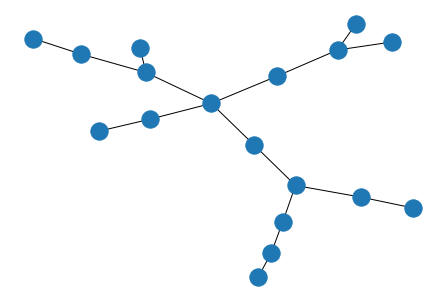

In [45]:
### OPENING COSINE SAVED DATA

# Similarity Matrices
SMpath = r'/Users/aj/JupyterNotebook/SMc.csv'
f = open(SMpath, "r") #open similarity matrix
r_SMc = (f.read().split('\n')) #array of each index of similarity matrix
r_SMc = r_SMc[:-1] #remove last blank newline from list 
#print(len(SMc))
#print(len(r_SMc))

# MST
MSTcNpath = r'/Users/aj/JupyterNotebook/MSTcNodes.csv'
MSTcEpath = r'/Users/aj/JupyterNotebook/MSTcEdges.csv'
f = open(MSTcNpath, "r") #open MST cosine Nodes
r_MSTcN = (f.read().split('\n')) #array of each index of similarity matrix
r_MSTcN = r_MSTcN[:-1] #remove last blank newline from list 
f = open(MSTcEpath, "r") #open MST cosine Edges
r_MSTcE = (f.read().split('\n')) #array of each index of similarity matrix
r_MSTcE = r_MSTcE[:-1] #remove last blank newline from list 
#print(r_MSTcN)
#print(r_MSTcE)

r_MSTcET = [] # split edges into tuples 
for x in r_MSTcE:
    temp = x.split(',')
    r_MSTcET.append(temp)
    
#print(r_MSTcET) # show edges are now tuples

r_MST = nx.Graph() # create graph
r_MST.add_nodes_from(r_MSTcN) # plot nodes
r_MST.add_edges_from(r_MSTcET) # plot edges between nodes 

#r_MST = nx.relabel_nodes(r_MST, all_sel_fam_names)
#nx.draw(r_MST, with_labels=True) # show graph 
#nx.draw(r_MST) # saved data graph
#nx.draw(gic)

In [46]:
# COSINE MST GIRVAN NEWMAN 
gnc_all_traces = all_traces_clusters_girvan_newman(r_MST, name_trace_dict, len(distinct_labels))

# COSINE MST LOUVAIN 
lvc_all_traces = all_traces_clusters_louvain(r_MST, name_trace_dict)


GIRVAN NEWMAN COMMUNITY DETECTION FAMILIES: 



Group  0 :   6, 55, 69, 73, 45, 51, 19, 22, 30, 60, 48, 

Group  1 :   23, 65, 17, 20, 85, 15, 7, 

LOUVAIN COMMUNITY DETECTION FAMILIES: 


Group  0 :  ['6', '22', '48', '55']

Group  1 :  ['17', '7', '23', '85']

Group  2 :  ['20', '65', '15']

Group  3 :  ['19', '51', '69']

Group  4 :  ['30', '45', '60', '73']


In [47]:
# COSINE MST GIRVAN NEWMAN 
gnc_all_traces = all_traces_clusters_girvan_newman(gic, name_trace_dict, len(distinct_labels))

# COSINE MST LOUVAIN 
lvc_all_traces = all_traces_clusters_louvain(gic, name_trace_dict)


GIRVAN NEWMAN COMMUNITY DETECTION FAMILIES: 



Group  0 :   69, 6, 73, 45, 48, 19, 51, 22, 55, 60, 30, 

Group  1 :   65, 7, 15, 17, 20, 85, 23, 

LOUVAIN COMMUNITY DETECTION FAMILIES: 


Group  0 :  [6, 22, 48, 55]

Group  1 :  [17, 7, 23, 85]

Group  2 :  [20, 65, 15]

Group  3 :  [19, 45, 51, 69]

Group  4 :  [30, 60, 73]


In [18]:
# ALL FAMILIES AND TRACES WITHIN THEM FOR EACH CONSTRUCTION METHOD

# print and return trace names within families they belong to 
def arr_of_families(all_traces_list):
    all_traces = all_traces_list[0]
    all_labels = all_traces_list[1]
    all_names = all_traces_list[2]
    
    distinct_labels = (sorted(list(set(all_labels))))
    
    families = []
    for x in range(len(distinct_labels)):
        temp = []
        for j in range(len(all_labels)): # check every label of the trace documents
            if all_labels[j] == x: # if the trace document label = the label
                temp.append(all_names[j]) # append the trace document name to the family list 
        
        families.append(temp)   
        
    for x in range(len(families)):
        print("Group ", distinct_labels[x], ": ")
        print(families[x], "\n") 
        
    return families

print("\n\nORIGINAL FAMILIES")
for x in range(len(original_families)):
    print("Group ", distinct_labels[x], ": ")
    print(original_families[x], "\n")    

print("\n\nGIRVAN NEWMAN JACCARD FAMILIES")
gnj_families = arr_of_families(gnj_all_traces)
print("\n\nLOUVAIN JACCARD FAMILIES")
lvj_families = arr_of_families(lvj_all_traces)
print("\n\nGIRVAN NEWMAN COSINE FAMILIES")
gnc_families = arr_of_families(gnc_all_traces)
print("\n\nLOUVAIN COSINE FAMILIES")
lvc_families = arr_of_families(lvc_all_traces)



ORIGINAL FAMILIES
Group  Adware : 
[6, 17, 20, 22, 48, 55, 65] 

Group  Backdoor : 
[7, 15, 19, 23, 30, 45, 51, 60, 69, 73, 85] 



GIRVAN NEWMAN JACCARD FAMILIES
Group  0 : 
[65, 69, 6, 7, 45, 17, 19, 51, 85, 22, 23] 

Group  1 : 
[73, 15, 48, 20, 55, 60, 30] 



LOUVAIN JACCARD FAMILIES
Group  0 : 
[6, 17, 22, 19, 45] 

Group  1 : 
[20, 48, 15] 

Group  2 : 
[55, 30, 60, 73] 

Group  3 : 
[65, 7, 23, 85] 

Group  4 : 
[51, 69] 



GIRVAN NEWMAN COSINE FAMILIES
Group  0 : 
[69, 6, 73, 45, 48, 19, 51, 22, 55, 60, 30] 

Group  1 : 
[65, 7, 15, 17, 20, 85, 23] 



LOUVAIN COSINE FAMILIES
Group  0 : 
[6, 22, 48, 55] 

Group  1 : 
[17, 7, 23, 85] 

Group  2 : 
[20, 65, 15] 

Group  3 : 
[19, 45, 51, 69] 

Group  4 : 
[30, 60, 73] 



In [19]:
### SENSITIVITY AND SPECIFICITY

def evaluate_families(original_families, constructed_families):
    families_similar_to = [] #original family that constructed family is most similar to
    sensitivity = [] #the sensitivity of each constructed family 
    specificity = [] #the specificity of each constructed family 
    
    all_or_fam_union = set([]) #set of all original family trace names 
    for y in (original_families):
        all_or_fam_union =all_or_fam_union.union(set(y))
    

    for y in range(len(original_families)):
        original_fam = set(original_families[y])
        max_same_traces = 0 #number of traces similar between constructed and original family
        similar_fam = 0 #which family is most similar to constructed family 
        
        for x in range(len(constructed_families)):
            constructed_fam = set(constructed_families[x])
            intersection = len(constructed_fam.intersection(original_fam))
            
            if intersection > max_same_traces: # if more similar traces than last original fam
                max_same_traces = intersection #set intersection as TRUE POSITIVE
                
                similar_fam = x # the original family that the constructed family is most similar to
                sens = (max_same_traces) / (len(original_families[y]))
                sens = round(sens, 2)
                
                false_pos = len(constructed_families[x]) - max_same_traces
                all_other_families = all_or_fam_union - set(original_families[y])
                spec = ((len(all_other_families)) - false_pos) / len(all_other_families)
                spec = round(spec, 2)
                
        families_similar_to.append(similar_fam)
        sensitivity.append(sens)
        specificity.append(spec)
        
    return families_similar_to, sensitivity, specificity
            
    
print("GNJ: ", evaluate_families(original_families, gnj_families))
print("LVJ: ", evaluate_families(original_families, lvj_families))
print("GNC: ", evaluate_families(original_families, gnc_families))
print("LVC: ", evaluate_families(original_families, lvc_families))

GNJ:  ([0, 0], [0.57, 0.64], [0.36, 0.43])
LVJ:  ([0, 2], [0.43, 0.27], [0.82, 0.86])
GNC:  ([0, 0], [0.57, 0.64], [0.36, 0.43])
LVC:  ([0, 3], [0.57, 0.36], [1.0, 1.0])


In [20]:
### CLASSIFICATION

Cross Validation: 
Naive Bayes:  [0.83333333 0.6        0.6       ] 
Decision Trees:  [0.83333333 0.8        0.8       ] 
Random Forest:  [1.  0.8 1. ]

CLASSIFICATION ACCURACY

Naive Bayes Accuracy:  1.0

Decision Tree Accuracy:  1.0

Random Forest Accuracy:  1.0

Confusion Matrix Metrics for Naive Bayes: 
               precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2
 
 [[1 0]
 [0 1]]

Confusion Matrix Metrics for Decision Tree: 
               precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000    

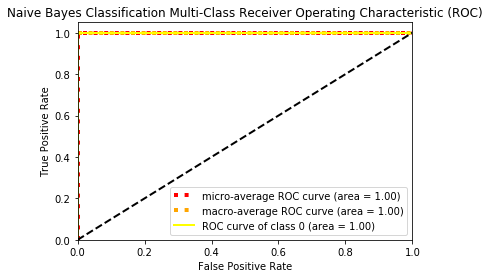

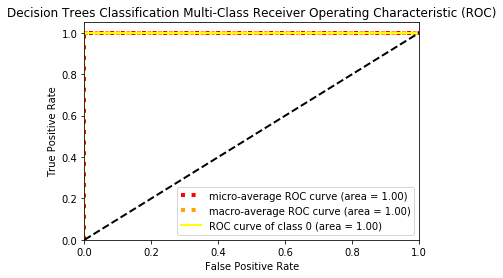

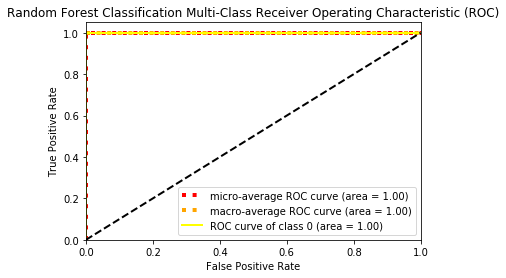

In [21]:
## JACCARD GIRVAN NEWMAN CLASSIFICATION
# split test train
gnj_train_features, gnj_test_features, gnj_train_labels, gnj_test_labels = features(gnj_all_traces)

# cross validation
cross_validation(gnj_train_features, gnj_train_labels)

# classification predictions
gnj_nbp, gnj_dtp, gnj_rfp = classification(gnj_train_features, gnj_test_features, gnj_train_labels, gnj_test_labels)

# evaluations
confusion_matrix_eval(gnj_test_labels, gnj_nbp, gnj_dtp, gnj_rfp)
roc_plot(gnj_test_labels, gnj_nbp, gnj_dtp, gnj_rfp)

In [22]:
## JACCARD LOUVAIN CLASSIFICATION
# split test train
lvj_train_features, lvj_test_features, lvj_train_labels, lvj_test_labels = features(lvj_all_traces)

# cross validation
cross_validation(lvj_train_features, lvj_train_labels)

# classification predictions
lvj_nbp, lvj_dtp, lvj_rfp = classification(lvj_train_features, lvj_test_features, lvj_train_labels, lvj_test_labels)

# evaluations
confusion_matrix_eval(lvj_test_labels, lvj_nbp, lvj_dtp, lvj_rfp)
#roc_plot(lvj_test_labels, lvj_nbp, lvj_dtp, lvj_rfp)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Cross Validation: 
Naive Bayes:  [0.33333333 0.6        0.4       ] 
Decision Trees:  [0.66666667 0.4        0.8       ] 
Random Forest:  [0.66666667 0.8        0.6       ]

CLASSIFICATION ACCURACY

Naive Bayes Accuracy:  0.0

Decision Tree Accuracy:  1.0

Random Forest Accuracy:  1.0

Confusion Matrix Metrics for Naive Bayes: 
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       0.0
           3      0.000     0.000     0.000       2.0

    accuracy                          0.000       2.0
   macro avg      0.000     0.000     0.000       2.0
weighted avg      0.000     0.000     0.000       2.0
 
 [[0 0]
 [2 0]]

Confusion Matrix Metrics for Decision Tree: 
               precision    recall  f1-score   support

           3      1.000     1.000     1.000         2

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2
 
 [[2

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
## COSINE GIRVAN NEWMAN CLASSIFICATION

# split test train
gnc_train_features, gnc_test_features, gnc_train_labels, gnc_test_labels = features(gnc_all_traces)

# cross validation
cross_validation(gnc_train_features, gnc_train_labels)

# classification predictions 
gnc_nbp, gnc_dtp, gnc_rfp = classification(gnc_train_features, gnc_test_features, gnc_train_labels, gnc_test_labels)

# evaluations
confusion_matrix_eval(gnc_test_labels, gnc_nbp, gnc_dtp, gnc_rfp)
#roc_plot(gnc_test_labels, gnc_nbp, gnc_dtp, gnc_rfp)

Cross Validation: 
Naive Bayes:  [1.  0.8 0.6] 
Decision Trees:  [0.83333333 0.6        0.8       ] 
Random Forest:  [0.83333333 0.8        0.6       ]

CLASSIFICATION ACCURACY

Naive Bayes Accuracy:  0.5

Decision Tree Accuracy:  0.0

Random Forest Accuracy:  0.5

Confusion Matrix Metrics for Naive Bayes: 
               precision    recall  f1-score   support

           0      0.500     1.000     0.667         1
           1      0.000     0.000     0.000         1

    accuracy                          0.500         2
   macro avg      0.250     0.500     0.333         2
weighted avg      0.250     0.500     0.333         2
 
 [[1 0]
 [1 0]]

Confusion Matrix Metrics for Decision Tree: 
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       1.0
           1      0.000     0.000     0.000       1.0

    accuracy                          0.000       2.0
   macro avg      0.000     0.000     0.000       2.0
weighted avg      0.000    

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
## COSINE LOUVAIN CLASSIFICATION

# split test train
lvc_train_features, lvc_test_features, lvc_train_labels, lvc_test_labels = features(lvc_all_traces)

# cross validation
cross_validation(lvc_train_features, lvc_train_labels)

# classification predictions 
lvc_nbp, lvc_dtp, lvc_rfp = classification(lvc_train_features, lvc_test_features, lvc_train_labels, lvc_test_labels)

# evaluations
confusion_matrix_eval(lvc_test_labels, lvc_nbp, lvc_dtp, lvc_rfp)
#roc_plot(lvc_test_labels, lvc_nbp, lvc_dtp, lvc_rfp)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Cross Validation: 
Naive Bayes:  [0.33333333 0.6        0.4       ] 
Decision Trees:  [0.33333333 0.4        0.4       ] 
Random Forest:  [0.33333333 0.4        0.4       ]

CLASSIFICATION ACCURACY

Naive Bayes Accuracy:  0.5

Decision Tree Accuracy:  0.5

Random Forest Accuracy:  0.5

Confusion Matrix Metrics for Naive Bayes: 
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         1
           3      1.000     1.000     1.000         1

    accuracy                          0.500         2
   macro avg      0.333     0.333     0.333         2
weighted avg      0.500     0.500     0.500         2
 
 [[0 0 0]
 [1 0 0]
 [0 0 1]]

Confusion Matrix Metrics for Decision Tree: 
               precision    recall  f1-score   support

           2      0.000     0.000     0.000         1
           3      0.500     1.000     0.667         1

    accuracy                          0.500    

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation: 
Naive Bayes:  [0.5 0.6 0.6] 
Decision Trees:  [0.83333333 0.6        0.4       ] 
Random Forest:  [0.5 0.8 0.4]

CLASSIFICATION ACCURACY

Naive Bayes Accuracy:  1.0

Decision Tree Accuracy:  1.0

Random Forest Accuracy:  1.0

Confusion Matrix Metrics for Naive Bayes: 
               precision    recall  f1-score   support

           1      1.000     1.000     1.000         2

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2
 
 [[2]]

Confusion Matrix Metrics for Decision Tree: 
               precision    recall  f1-score   support

           1      1.000     1.000     1.000         2

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2
 
 [[2]]

Confusion Matrix Metrics for Random Forest: 
               precision    recall  f1-score   support



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:788: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


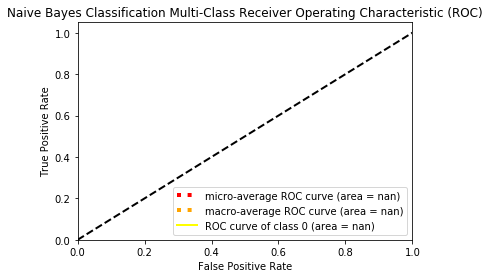

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:788: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


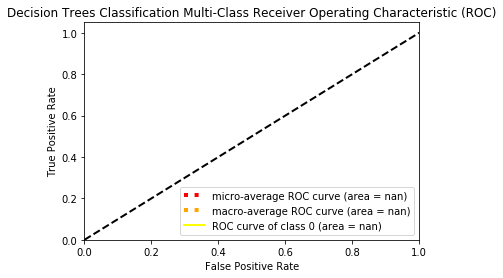

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:788: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


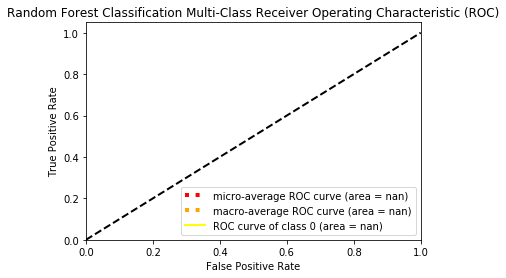

In [22]:
### ORIGINAL DATASET FAMILIES CLASSIFICATION

# split test train
otrain_features, otest_features, otrain_labels, otest_labels = features(all_traces_list)

# cross validation
cross_validation(otrain_features, otrain_labels)

# classification predictions 
onbp, odtp, orfp = classification(otrain_features, otest_features, otrain_labels, otest_labels)

# evaluations
confusion_matrix_eval(otest_labels, onbp, odtp, orfp)
roc_plot(otest_labels, onbp, odtp, orfp)